## Markov chains for finding CpG islands

In [1]:
from __future__ import print_function
import random
import re
import gzip
from itertools import islice
from operator import itemgetter
import numpy as np

from future.standard_library import install_aliases
install_aliases()
from urllib.request import urlopen, urlcleanup, urlretrieve

As training data, we use some already-called CpG islands.  These were called in a prior study that used a kind of Hidden Markov Model.  Relevant studies:

* A species-generalized probabilistic model-based definition of CpG islands. Irizarry RA, Wu H, Feinberg AP. [doi:10.1007/s00335-009-9222-5](https://doi.org/10.1007/s00335-009-9222-5)
* Redefining CpG islands using hidden Markov models.  Wu H, Caffo B, Jaffee HA, Irizarry RA, Feinberg AP. [doi:10.1093/biostatistics/kxq005](https://doi.org/10.1093/biostatistics/kxq005)

In [2]:
islands_url = 'http://www.haowulab.org/software/makeCGI/model-based-cpg-islands-hg19.txt'

# URL for chromosome of the hg19 human genome assembly
def hg19_chr_url(chrom):
    return 'ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/%s.fa.gz' % chrom

In [3]:
def sample(iterable, n):
    """ Samples n items from a stream """
    samp = []
    for t, item in enumerate(iterable):
        if t < n:
            samp.append(item)
        else:
            m = random.randint(0, t)
            if m < n:
                samp[m] = item
    return samp

In [4]:
def kmers_from_fasta(fh, k):
    """ Yield k-mer, offset pairs from FASTA filehandle.
        Ignore k-mers with chars besides A, C, G or T. """
    non_acgt = re.compile('[^ACGTacgt]')  # regex for detecting non-A/C/G/Ts
    kmer, off = [], 0
    for ln in fh:
        if ln[0] == r'>':
            kmer, off = [], 0  # new sequence
            continue
        for c in filter(lambda x: x.isalpha(), ln.decode()):
            if len(kmer) == k:
                kmer.pop(0)  # k-mer buffer full, so bump one element
            kmer.append(c.upper())
            off += 1
            if len(kmer) == k:
                kmerstr = ''.join(kmer)
                if not non_acgt.search(kmerstr):
                    yield kmerstr, off - k

In [5]:
def kmers_islands_from_fasta(fh, k, isles, want_inside):
    """ Yield k-mers along with string indicating whether k-mer lies
        entirely within an island (True) or not (False) """
    cur = 0
    for kmer, off in kmers_from_fasta(fh, k):
        while cur < len(isles) and off >= isles[cur][1]:
            cur += 1
        was_inside = False
        if cur < len(isles) and off >= isles[cur][0]:
            if off + k <= isles[cur][1]:
                was_inside = True
                if want_inside:
                    yield kmer
        if not was_inside and not want_inside:
            yield kmer

In [6]:
def parse_islands(fh, chromosome):
    """ Parse a file with island annotations. Only take
        records from given chromosome name. """
    islands = []
    for ln in fh:
        ch, st, en, _ = ln.split(b'\t', 3)
        if ch == chromosome.encode('utf8'):
            # convert 1-based closed interval to 0-based right-open
            islands.append((int(st)-1, int(en)))
    return islands

In [7]:
def get_islands(chromosome):
    with urlopen(islands_url) as fh:
        return parse_islands(fh, chromosome)  # takes a few seconds

Islands are described simply as a pair of numbers giving the 0-based right open interval for each island.

In [8]:
get_islands('chr22')[1:10]

[(16096917, 16097083),
 (16097226, 16097940),
 (16122658, 16123497),
 (16155779, 16157985),
 (16192710, 16193099),
 (16200190, 16202154),
 (16216495, 16218123),
 (16227376, 16227533),
 (16228205, 16228802)]

In [9]:
def kmers_islands_from_hg19(k, chromosome, islands, inside):
    fa_fn, _ = urlretrieve(hg19_chr_url(chromosome))
    with gzip.open(fa_fn, 'rb') as fa_fh:
        # Yield all the k-mer tuples
        for r in kmers_islands_from_fasta(fa_fh, k, islands, inside):
            yield r

In [10]:
def samples_from_hg19(k, chromosome, n, upto):
    """ Given given k, and n, sample n k-mers from both inside
        and outside CpG islands, then return histograms of number
        of times each k-mer occurs inside and outside. """
    islands = get_islands(chromosome)
    ins = sample(islice(kmers_islands_from_hg19(
        k, chromosome, islands, True), upto), n)
    out = sample(islice(kmers_islands_from_hg19(
        k, chromosome, islands, False), upto), n)
    return ins, out

Our first idea for a model is to count how many times our $k$-mer of interest occurs inside and outside CpG islands.  This get problematic as $k$ grows as it requires exponentially more training data.

In [11]:
from collections import Counter

random.seed(723444)
q = 'CGCGC'
n = 500000
upto = 5000000
ins, out = samples_from_hg19(len(q), 'chr22', n, upto)
assert len(ins) == n, (len(ins), len(out), n)
assert len(out) == n, (len(ins), len(out), n)
hist_in, hist_out = Counter(ins), Counter(out)

# print info about inside/outside counts and probabilities
print("inside: %d out of %d" % (hist_in[q], n))
print("outside: %d out of %d" % (hist_out[q], n))
print("p(inside): %0.5f" % (float(hist_in[q]) / (hist_in[q] + hist_out[q])))
print("p(outside): %0.5f" % (float(hist_out[q]) / (hist_in[q] + hist_out[q])))

inside: 1553 out of 500000
outside: 45 out of 500000
p(inside): 0.97184
p(outside): 0.02816


Now we adopt the Markov assumption and estimate all the conditional probabilities, e.g. $P(A|C)$.

In [12]:
# Now to build inside and outside Markov chains

# compile dinucleotide tables
samp_in, samp_out = samples_from_hg19(2, 'chr22', n=100000, upto=1000000)

In [13]:
def markov_chain_from_dinucs(dinucs):
    ''' Given dinucleotide frequencies, make a transition table. '''
    conds = np.zeros((4, 4), dtype=np.float64)
    margs = np.zeros(4, dtype=np.float64)
    for i, ci in enumerate('ACGT'):
        tot = 0
        for j, cj in enumerate('ACGT'):
            count = dinucs.get(ci + cj, 0)
            tot += count
            margs[i] += count
        if tot > 0:
            for j, cj in enumerate('ACGT'):
                conds[i, j] = dinucs.get(ci + cj, 0) / float(tot)
    return conds, margs

In [14]:
ins_conds, ins_margs = markov_chain_from_dinucs(Counter(samp_in))
out_conds, out_margs = markov_chain_from_dinucs(Counter(samp_out))

In [15]:
# transition probabilities inside CpG island
ins_conds

array([[ 0.18427153,  0.27129525,  0.4055757 ,  0.13885752],
       [ 0.19081672,  0.36113346,  0.24897947,  0.19907035],
       [ 0.17440554,  0.32764433,  0.35676759,  0.14118254],
       [ 0.09348595,  0.3474561 ,  0.36885   ,  0.19020795]])

In [16]:
# confirm that rows add to 1
np.sum(ins_conds, 1), np.sum(out_conds, 1)

(array([ 1.,  1.,  1.,  1.]), array([ 1.,  1.,  1.,  1.]))

In [17]:
# elementwise log2 of above table
np.log2(ins_conds)

array([[-2.44009488, -1.8820643 , -1.30195688, -2.84832282],
       [-2.38974049, -1.469396  , -2.00590131, -2.32864974],
       [-2.51948223, -1.60979755, -1.48694353, -2.82436637],
       [-3.41910668, -1.52509737, -1.43889385, -2.39435058]])

In [18]:
# log ratio table
np.log2(ins_conds) - np.log2(out_conds)

array([[-0.87536356,  0.59419041,  0.81181564, -0.85527103],
       [-0.98532149,  0.49570561,  2.64256972, -0.7126391 ],
       [-0.79486196,  0.68874785,  0.51821792, -0.79549511],
       [-1.22085697,  0.73036913,  0.48119354, -0.69736839]])

In [19]:
def classify(seq, lrTab):
    """ Classify seq using given log-ratio table.  We're ignoring the
        initial probability for simplicity. """
    bits = 0
    nucmap = { 'A':0, 'C':1, 'G':2, 'T':3 }
    for dinuc in [ seq[i:i+2] for i in range(len(seq)-1) ]:
        i, j = nucmap[dinuc[0]], nucmap[dinuc[1]]
        bits += lrTab[i, j]
    return bits

In [20]:
log_ratios = np.log2(ins_conds) - np.log2(out_conds)

In [21]:
classify('CGCGCGCGCGCGCGCGCGCGCGCGCG', log_ratios)

42.618380534506265

In [22]:
classify('ATTCTACTATCATCTATCTATCTTCT', log_ratios)

-10.839270703924727

In [23]:
itest, otest = samples_from_hg19(100, 'chr18', 1000, 100000)

In [24]:
itestClass = [ classify(x, log_ratios) for x in itest ]
otestClass = [ classify(x, log_ratios) for x in otest ]

Populating the interactive namespace from numpy and matplotlib


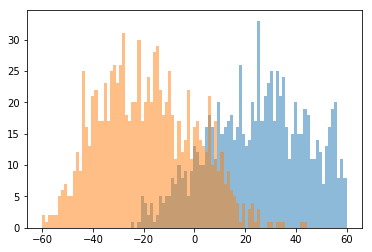

In [25]:
%pylab inline --no-import-all
from matplotlib import pyplot
bins = numpy.linspace(-60, 60, 100)
pyplot.hist(itestClass, bins, alpha=0.5)
pyplot.hist(otestClass, bins, alpha=0.5)
pyplot.show()